In [1]:
import automlx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from automlx import init
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [2]:
# Fetch example data set
dataset = fetch_openml(name='adult', version=1, as_frame=True, parser='auto')
df, y = dataset.data, dataset.target

In [3]:
# Output header data for quick inspection
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [4]:
# Output default data types detected by the fetch (notice all are not correct, e.g., see "age" incorrectly listed as "category")
pd.DataFrame({'Data type': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
Data type,category,category,int64,category,int64,category,category,category,category,category,category,category,category,category


In [5]:
# Output % missing values per column
pd.DataFrame({'% missing vlaues': df.isnull().sum() * 100 / len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
% missing vlaues,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637


[Text(0, 0, '37155'), Text(0, 0, '11687')]

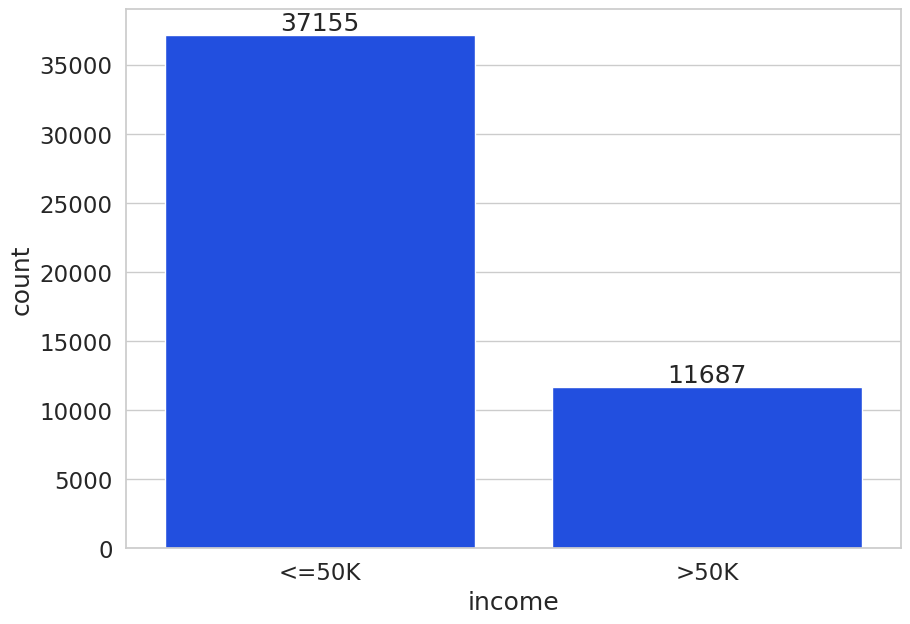

In [6]:
# visualize the distribution of the target variable (income)
y_df = pd.DataFrame(y)
y_df.columns = ['income']

ax = sns.countplot(x="income", data=y_df)
ax.bar_label(ax.containers[0])

In [7]:
# Correct the incorrect column data types
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)
        
        
# Split the data set into training and test data
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y.map({'>50K': 1, '<=50K': 0}).astype(int),
                                                    train_size=0.7,
                                                    random_state=0)

# Output the shap of the training and test data sets
X_train.shape, X_test.shape

((34189, 14), (14653, 14))

In [8]:
# Initialize the AutoML Engine, setting it to use Python's parallelism library
init(engine='local')

In [9]:
# Create and fit a model using the AutoML Piepline (Preprocessing > Algorithm Selection > Adaptive Sampling > Feature Selection > Hyperparameter Tuning)
est1 = automlx.Pipeline(task='classification')
est1.fit(X_train, y_train)

[2025-12-04 16:36:28,491] [automlx.interface] Dataset shape: (34189,14)
[2025-12-04 16:36:28,577] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-12-04 16:36:29,660] [automlx.data_transform] Preprocessing completed. Took 1.083 secs
[2025-12-04 16:36:29,668] [automlx.process] Running Model Generation
[2025-12-04 16:36:29,721] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-12-04 16:36:29,722] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-12-04 16:36:29,724] [automlx.process] Model Generation completed.
[2025-12-04 16:36:29,799] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2000, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002625 seconds.
You

In [10]:
# Evaluate the effectiveness of the module
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score_default}')

Score on test data: 0.9140858492615117


In [11]:
# Summarize the AutoML activity
est1.print_summary()

""
"(34189, 14)"
None
"KFoldSplit(Shuffle=True, Seed=7, folds=5, stratify by=target)"
neg_log_loss
XGBClassifier
"{'learning_rate': 0.10242113515453982, 'min_child_weight': 2, 'max_depth': 4, 'reg_alpha': 0.0007113117640155693, 'booster': 'gbtree', 'reg_lambda': 1.001, 'n_estimators': 141, 'use_label_encoder': False}"
25.1.1
"3.11.11 | packaged by conda-forge | (main, Mar 3 2025, 20:43:55) [GCC 13.3.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_log_loss),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3813,{'neg_log_loss': -0.38129734602336923},2.2744,0.2877,Thu Dec 4 16:38:29 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",-0.3881,{'neg_log_loss': -0.38808832474759775},5.9926,0.3088,Thu Dec 4 16:36:39 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",-0.3898,{'neg_log_loss': -0.3898051926295403},6.2791,0.2696,Thu Dec 4 16:36:53 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",-0.3908,{'neg_log_loss': -0.3907935186356912},0.4291,0.2562,Thu Dec 4 16:38:30 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",-0.4093,{'neg_log_loss': -0.40930045927988684},6.5786,0.2670,Thu Dec 4 16:36:59 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",-0.4196,{'neg_log_loss': -0.4196315514455088},4.5753,0.2677,Thu Dec 4 16:36:45 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,TorchMLPClassifier,"{'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 128, 'lr': 0.001, 'epochs': 18, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'depth': 4, 'num_logits': 1000, 'div_factor': 2, 'activation': 'ReLU', 'dropout': 0.1}",-0.6601,{'neg_log_loss': -0.6600503003077061},86.9215,0.6677,Thu Dec 4 16:38:27 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,GaussianNB,{},-1.0622,{'neg_log_loss': -1.0622002049203993},0.7728,0.2600,Thu Dec 4 16:36:46 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",-4.6323,{'neg_log_loss': -4.632288461805368},0.5612,0.2613,Thu Dec 4 16:36:40 2025
Adaptive Sampling,"{1: 6730, 2: 6730, 3: 6730, 4: 6730, 5: 6730}",15,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3782,{'neg_log_loss': -0.37817011702109865},3.6215,0.3010,Thu Dec 4 16:38:40 2025


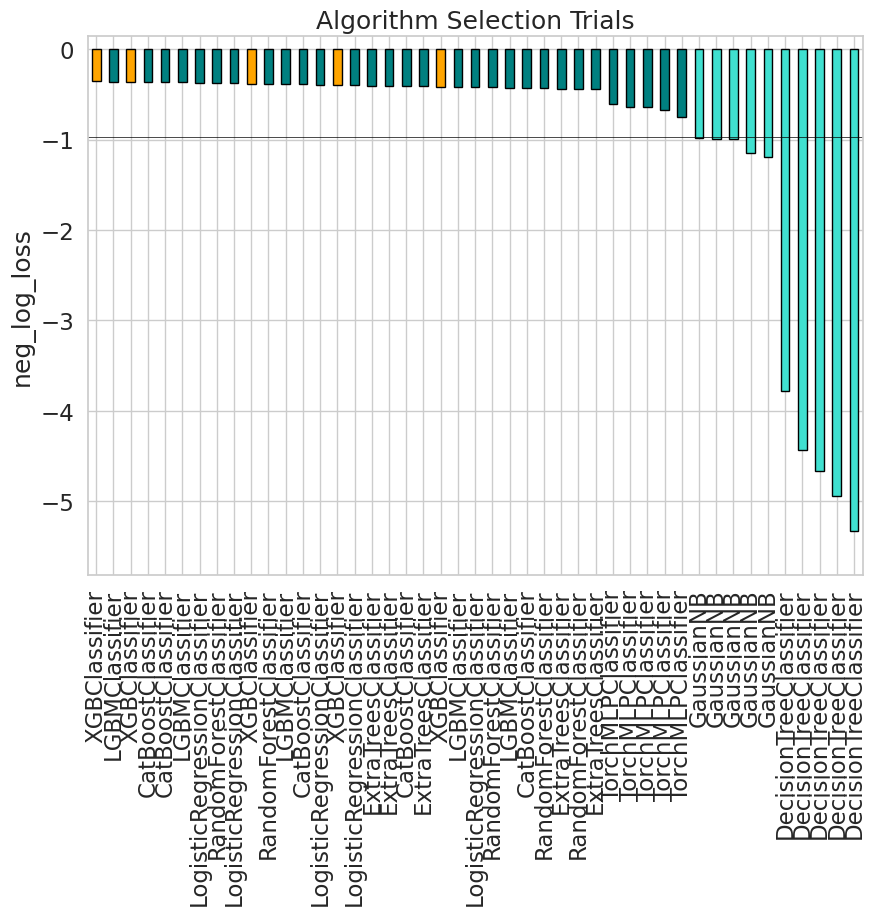

In [12]:
# Graph the results from the "Model Selection" step/stage
trials_raw = est1.completed_trials_detailed_
trials = trials_raw[trials_raw['Step'] == 'Model Selection']

colors = []
scores = trials['Score (neg_log_loss)'].tolist()
models = trials['Algorithm'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

for index, value in s.items():
    if index == est1.selected_model_:
        colors.append('orange')
    elif value >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        
fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel('neg_log_loss')
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

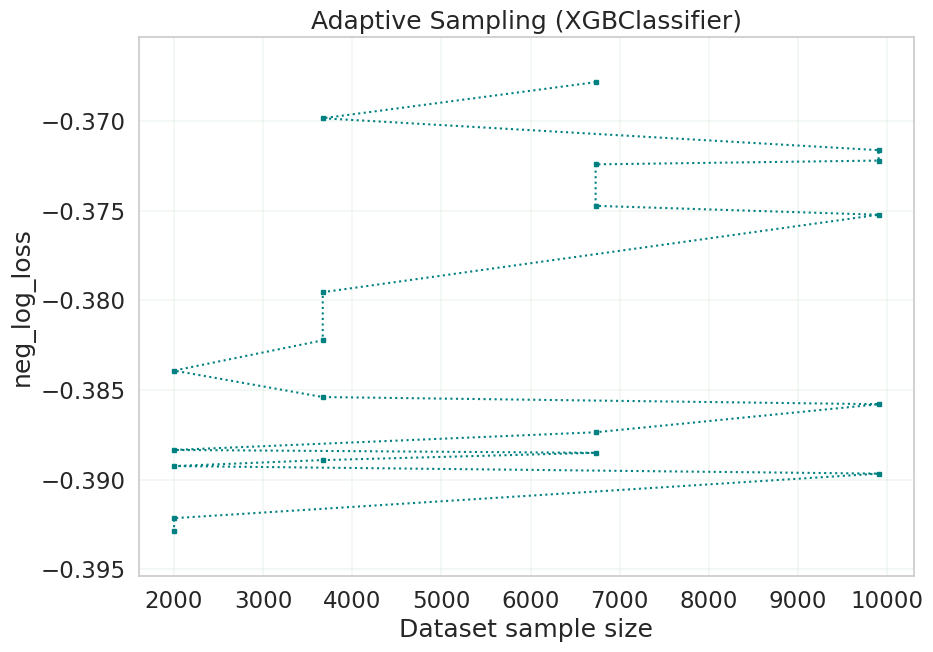

In [13]:
# Graph the results from the "Adaptive Sampling" step/stage
trials = trials_raw[trials_raw['Step'] == 'Adaptive Sampling']
trials = trials[trials['Score (neg_log_loss)'] != -np.inf ]

scores    = trials['Score (neg_log_loss)'].tolist()
models    = trials['Algorithm'].tolist()
n_samples = trials['# Samples'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
        
fig, ax = plt.subplots(1)
ax.set_title("Adaptive Sampling ({})".format(models[0].removeprefix("AdaptiveSamplingStage_")))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel('neg_log_loss')
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_samples, scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

Features selected: ['age', 'capitalgain', 'capitalloss', 'education', 'education-num', 'fnlwgt', 'hoursperweek', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex_1', 'sex_2', 'workclass']
Features available: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'native-country']
Features dropped: Index(['sex'], dtype='object')


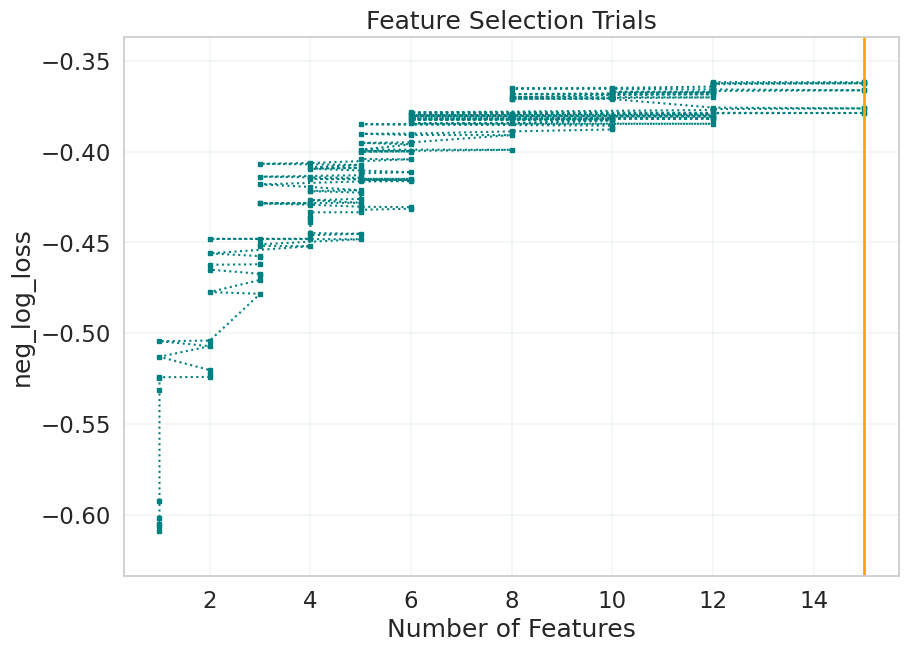

In [14]:
# Graph the results from the "Feature Selection" step/stage
print(f"Features selected: {est1.selected_features_names_}")
print(f"Features available: {df.keys().tolist()}")
dropped_features = df.keys().drop(est1.selected_features_names_, errors='ignore')
print(f"Features dropped: {dropped_features}") # <-- Need to take this output with a grain of salt as AutoMLX seemed to add "_#" indexes to ceratin feature names
 
trials = trials_raw[trials_raw['Step'] == 'Feature Selection']

scores    = trials['Score (neg_log_loss)'].tolist()
models    = trials['Algorithm'].tolist()
n_features = trials['# Features'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
        
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel('Number of Features')
ax.set_ylabel('neg_log_loss')
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

Text(83.25, 0.5, 'Actual')

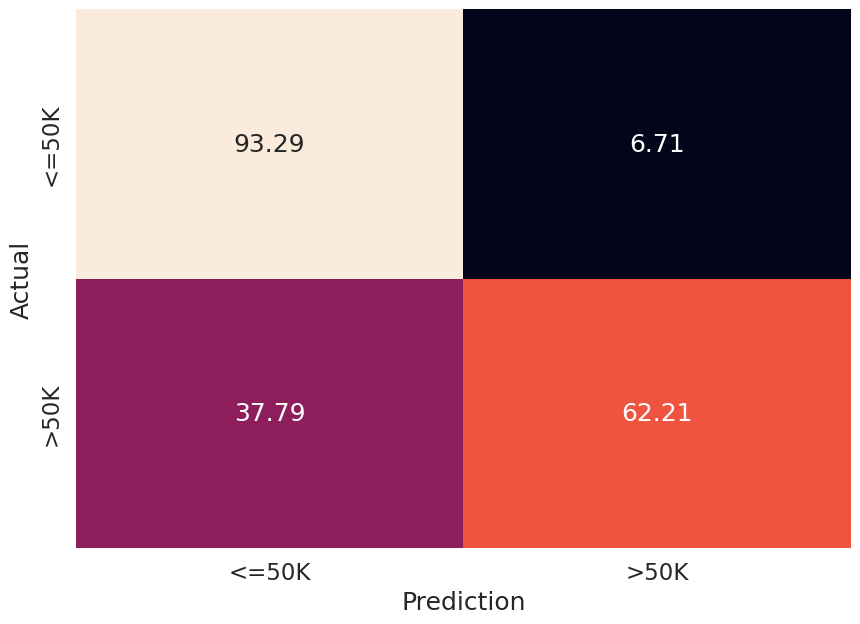

In [15]:
# Graphy the confusion matrix for our pipeline
y_pred = est1.predict(X_test)
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm)
df_cm = df_cm * 100

ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cbar=False, xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [16]:
## Pipeline Variation - Provide a specific model list to AutoML
#est2 = automlx.Pipeline(model_list=['RandomForestClassifier']) # Default task type is "classification"
#est2.fit(X_train, y_train)
#y_proba = est2.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [17]:
## Pipeline Variation - Use a custom validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=0)
#
#est3 = automlx.Pipeline()
#est3.fit(X_train, y_train, X_val, y_val)
#y_proba = est3.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [18]:
## Pipeline Variation - Increase the number of tuned models
#est4 = automlx.Pipeline(n_algos_tuned=2, model_list=['GaussianNB', 'RandomForestClassifier', 'XGBClassifier'])
#est4.fit(X_train, y_train)
#
#y_proba = est4.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [19]:
## Pipeline Variation - Specify a different scoring metric to AutoML
#est5 = automlx.Pipeline(score_metric='accuracy', model_list=['XGBClassifier'])
#est5.fit(X_train, y_train)
#
#y_proba = est5.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [20]:
## Pipeline Variation - Specify a user defined scoring function to AutoML
##score_fn = make_scorer(f1_score, greater_is_better=True, needs_proba=False, average='macro')
#def custom_mae_scorer(y_true, y_pred):
#    """
#    Custom Mean Absolute Error scorer.
#    AutoMLx expects a function that takes (y_true, y_pred) as input.
#    """
#    def __init__(self, name="custom_mae_scorer"):
#        self.__name__ = name
#        self.y_true = y_true
#        self.y_pred = y_pred
#    
#    return -mean_absolute_error(y_true, y_pred) # Return negative for optimization (AutoMLx maximizes scores)
#
#est6 = automlx.Pipeline(
#    task='classification',
#    score_metric=custom_mae_scorer, # Or custom_mae_scorer if not using make_scorer
#    random_state=42
#)
#est6.fit(X_train, y_train)
#
#y_proba = est6.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [21]:
## Pipeline Variation - Specify a time budget to AutoML
#est7 = automlx.Pipeline()
#est7.fit(X_train, y_train, time_budget=30) # <-- This made an amazing difference in auto-modeling time, but did not change the score substantially
#
#y_proba = est7.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')

In [22]:
## Pipeline Variation - Specify minimum set of features
#est8 = automlx.Pipeline(min_features=['fnlwgt', 'native-country'], model_list=['XGBClassifier'])
#est8.fit(X_train, y_train)
#
#y_proba = est8.predict_proba(X_test)
#score_modellist = roc_auc_score(y_test, y_proba[:, 1])
#
#print(f'ROC AUC Score on test data: {score_modellist}')
#print(f'Selected features: {est8.selected_features_names_}')